In [1]:
# using Pkg
# Pkg.add(["DifferentialEquations", "ControlSystems"])
using DifferentialEquations
using LinearAlgebra
using ControlSystems
using Plots
using Distributions

In [2]:
# Convenience Functions
eye(n_dim) = zeros(n_dim, n_dim) + I  # Why doesn't this already exist?

eye (generic function with 1 method)

In [3]:
# The following functions are used to render the animation of the cartpole.

@userplot CartPolePlot
@recipe function f(cpp::CartPolePlot)
    x, θ = cpp.args
    
    # pi is directly up
    θ = θ - π/2

    cart_width = 0.50
    cart_height = 0.25
    cart = Shape(x .+ [-cart_width / 2, cart_width / 2,cart_width / 2, -cart_width / 2], [0,0,cart_height,cart_height])
    
    pole_length = 1.0
    mass_width = 0.10
    mass_x = pole_length * cos(θ) + x
    mass_y = pole_length * sin(θ)

    
    pole = Shape([(x, 0), (mass_x, mass_y)])
    mass = Shape([
            (mass_x - mass_width / 2, mass_y + mass_width / 2),
            (mass_x + mass_width / 2, mass_y + mass_width / 2),
            (mass_x + mass_width / 2, mass_y - mass_width / 2),
            (mass_x - mass_width / 2, mass_y - mass_width / 2)
            ])
    
    ylims --> (-1,3)
    xlims --> (-1,5)
    size --> (600, 400)
    [pole, cart, mass]
    
end

function animate_solution(sol, t0, tstep, tf, filename)
    anim = @animate for t ∈ collect(t0:tstep:tf)
        u = sol(t)
        x = u[1]
        θ = u[3]
        cartpoleplot(x, θ)
    end
    gif(anim, filename, fps=20)  # Need to clear up how fps works exactly...
end


animate_solution (generic function with 1 method)

In [4]:
# ẋ = Ax + Bu + wd
# y = Cx + Du + wn

# x is n x 1 where n is the number of states
# A is n x n
# u is r X 1 
# B is n x r where r is the number of inputs
# C is m X n where m is the number of measurements
# D is m X r; feedthrough constant



In [5]:
# This function contains the dynamics for the pendcart
# and provides interfaces to include a controller and estimator.

function pendcart!(d𝐱, 𝐱, p, t)

    # position, velocity, angle, angular velocity
    x, v, θ, ω = 𝐱
    
    # pendulum mass, cart mass, pendulum length, gravity, cart damping, force
    m = p[1]  # pendulum mass
    M = p[2]  # cart mass
    L = p[3]  # pendulum length
    g = p[4]  # gravity
    δ = p[5]  # cart damping
    force = p[6]
    
    # Add disturbances 
    if length(p) == 7
        wd = [
            rand(Normal(0.0, p[7][1])),
            rand(Normal(0.0, p[7][2])),
            rand(Normal(0.0, p[7][3])),
            rand(Normal(0.0, p[7][4]))
        ]
    else
        wd = [0.0, 0.0, 0.0, 0.0]
    end
    
    # Simulate the dynamics of the pend cart
    Sx = sin(θ)
    Cx = cos(θ)
    D = m * L^2 * (M + m * (1 - Cx^2))
    
    d𝐱[1] = v
    d𝐱[2] = (1/D) * (-m^2*L^2*g*Cx*Sx + m*L^2*(m*L*ω^2*Sx - δ*v)) + m*L^2*(1/D)*force
    d𝐱[3] = ω
    d𝐱[4] = (1/D) * ((m+M)*m*g*L*Sx - m*L*Cx*(m*L*ω^2*Sx - δ*v)) - m*L*Cx*(1/D)*force
    
    d𝐱 = d𝐱 + wd
end

pendcart! (generic function with 1 method)

In [6]:
# Define the constants for this model

m = 1.0  # pendulum mass
M = 5.0  # cart mass
L = 2.0  # pendulum length
g = -10.0  # gravity pseudo-Earth
δ = 1.0  # cart damping
force = 0.0

0.0

In [7]:
# Define linearized model around the pendulum in the up position.
# This model is for a discretized model with full state feedabck.

A = [
    0 1 0 0;
    0 -δ/M m*g/M 0;
    0 0 0 1;
    0 -δ/(M*L) -(m+M)*g/(M*L) 0  
]

B = [0 1/M 0 1/(M*L)]'

# Can play around with weighting the diag values to tune conrol objectives
Q = [
    100 0 0 0
    0 0.1 0 0
    0 0 10 0
    0 0 0 1
]

R = 0.0001  # I don't have a good intuition around R here.

Kr = lqr(A, B, Q, R)

wr = [1, 0, π, 0]

𝐱̂ = [0.0,1.0,π,0.1]

C = [1.0 0.0 0.0 0.0]

Vd = eye(4)
Vn = 1

Kf = (lqr(A', C', Vd, Vn))'

function controller(integrator)
    # Update X position set point.
    if integrator.t > 12
        # After 12 seconds go to 0
        wr[1] = 0
    elseif integrator.t > 7
        # After 7 seconds go to 2
        wr[1] = 2
    end
    
    # measure x position
    noise = 0.0
    y = integrator.u[1] + noise
    
    # Set force input
    integrator.p[6] = (-Kr*(integrator.u - wr))[1,1] 
end

Δt = 0.01

cb = PeriodicCallback(controller, Δt)

u0 = [0.0,1.0,π,0.1] # x, v, θ, ω
tspan = (0.0,20.0)
p = [m, M, L, g, δ, force]
prob = ODEProblem(pendcart!,u0,tspan,p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, callback=cb)

plot(sol)

┌ Info: Saved animation to 
│   fn = /Users/ericmassey/hello_julia_lang/cartpole_animation_full_state_feedabck.gif
└ @ Plots /Users/ericmassey/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/Users/ericmassey/hello_julia_lang/cartpole_animation_full_state_feedabck.gif")
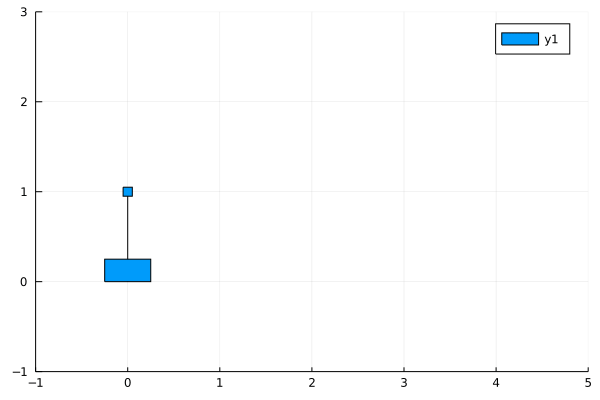

In [8]:
# Animate the Solution with no control.
animate_solution(sol, 0, 0.05, 20, "cartpole_animation_full_state_feedabck.gif" )

In [9]:
# A has a positive eigenvalue at pole in the verticle position so we know this fixed point is unstable.
eigvals(A)

4-element Array{Float64,1}:
 -2.4311230004720983
 -0.23363938083350477
  0.0
  2.464762381305604

In [10]:
# A, B are controllable given full rank controllability Matrix.
rank(ctrb(A, B))

4

In [11]:
# Linearized Model at pendulum up.
A = [
    0 1 0 0;
    0 -δ/M m*g/M 0;
    0 0 0 1;
    0 -δ/(M*L) -(m+M)*g/(M*L) 0  
]

B = [0 1/M 0 1/(M*L)]'

Δt = 0.01

# Can play around with weighting the diag values to tune conrol objectives
Q = [
    100 0 0 0
    0 0.1 0 0
    0 0 10 0
    0 0 0 1
]

R = 0.0001  # I don't have a good intuition around R here.

Kr = lqr(A, B, Q, R)

wr = [1, 0, π, 0]

C = [1.0 0.0 0.0 0.0]

Vd = eye(4)
Vn = 1

Kf = (lqr(A', C', Vd, Vn))'

# Discretize the controller.
F = exp(A*Δt)
G = F * (eye(4) - exp(-A*Δt)) * A'* B
H = eye(4)
𝐱̂ = [0.0, 1.0, π, 0.1]

# Set the disturbance variances.
wσ = [0.01, 0.01, 0.01, 0.01]
Q = wσ * wσ'

# Set the measurement error variances.
vσ = [0.01, 0.01, 0.01, 0.01]
R = vσ * vσ'

# Calculate Kalman Gain
P₀ = eye(4)
P⁻ₖ = F * P₀ * F' + Q
Kₖ = P⁻ₖ * H' * inv(H*P⁻ₖ*H' + R)

# Build new control with Kalman Filter
function controller(integrator)
    # Update X position set point.
    if integrator.t > 12
        # After 12 seconds go to 0
        wr[1] = 0
    elseif integrator.t > 7
        # After 7 seconds go to 2
        wr[1] = 2
    end
    
    vd = [
            rand(Normal(0.0, vσ[1])),
            rand(Normal(0.0, vσ[2])),
            rand(Normal(0.0, vσ[3])),
            rand(Normal(0.0, vσ[4]))
        ]
    yₖ = integrator.u + vd
    
    𝐱̂⁺ₖ₋₁ = 𝐱̂
    uₖ₋₁ = integrator.p[6]  # Input Force on cart.
    
    𝐱̂⁻ₖ = F * 𝐱̂⁺ₖ₋₁ + G * uₖ₋₁ # Before updating with y
    𝐱̂⁺ₖ = 𝐱̂⁻ₖ + Kₖ * (yₖ - H * 𝐱̂⁻ₖ) # After updating with y
    
    # Set force input.
    uₖ = (-Kr*(𝐱̂⁺ₖ - wr))[1,1]
    
    global 𝐱̂ = 𝐱̂⁺ₖ
    integrator.p[6] = uₖ  
end

# This is used to apply the discritized controller on the "continuous" model.
cb = PeriodicCallback(controller, Δt)

u0 = [0.0,1.0,π,0.1] # x, v, θ, ω
tspan = (0.0,20.0)
p = [m, M, L, g, δ, force, wσ]
prob = ODEProblem(pendcart!,u0,tspan,p)
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8, callback=cb)

plot(sol)

In [ ]:
# Animate the Solution with kalman filter on noisey measurements and disturbances.
animate_solution(sol, 0, 0.05, 20, "cartpole_animation_kalman.gif" )

**Initialization**

1. Initialize the state of the filter
2. Initialize our belief in the state

**Predict**

1. Use process model to predict state at the next time step
2. Adjust belief to account for the uncertainty in prediction 

**Update**

1. Get a measurement and associated belief about its accuracy
2. Compute residual between estimated state and measurement
3. Compute scaling factor based on whether the measurement
or prediction is more accurate
4. set state between the prediction and measurement based 
on scaling factor
5. update belief in the state based on how certain we are 
in the measurement